Goal 
==============================
In this notebook, I am trying to get the **best weights to predict _NYT Picked comments_**.

In [40]:
from sklearn import svm, linear_model, preprocessing, cross_validation
from sklearn.feature_selection import SelectPercentile, f_classif
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.plotting import *
from bokeh.charts import Histogram,Bar, Scatter
output_notebook()


# Data Loading

We will load the following data

- **feature matrix**
- **label vector**

$$
{\rm feature~matrix:~~~} {\bf X}~=~\left[
\begin{matrix}
x_{11} & x_{12} & \cdots & x_{1D}\\
x_{21} & x_{22} & \cdots & x_{2D}\\
x_{31} & x_{32} & \cdots & x_{3D}\\
\vdots & \vdots & \ddots & \vdots\\
\vdots & \vdots & \ddots & \vdots\\
x_{N1} & x_{N2} & \cdots & x_{ND}\\
\end{matrix}
\right]
$$

$$
{\rm label~vector:~~~} {\bf y}~=~ [y_1, y_2, y_3, \cdots y_N]
$$

Here there are $N$ samples and $D$ features.


In [41]:
# X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
# y = np.array([1, 1, 2, 2])

score = pd.DataFrame()

for i in range(3):
    filename = 'data/score' + str(i+1) + '.csv' 
    score = score.append( pd.read_csv(filename) )
    
                       
score4 = pd.read_csv('data/score4.csv')
score5 = pd.read_csv('data/score5.csv')
# score3 = pd.read_csv('data/score3.csv')

score4 = score4[score4.EditorsSelection == 1]

score5 = score5[score5.EditorsSelection == 1]

score = score.append(score4)
score = score.append(score5)

score = score.reset_index(drop=True)

In [42]:
# merged_score = score

# merged_score = score.reindex(np.random.permutation(score.index))

merged_score = score

feature_label = ['ArticleRelevance','AVGcommentspermonth','AVGBrevity','AVGPersonalXP','AVGPicks','AVGReadability','AVGRecommendationScore','Brevity','ConversationalRelevance','PersonalXP','Readability'];
selected_score = merged_score[['ArticleRelevance','AVGcommentspermonth','AVGBrevity','AVGPersonalXP','AVGPicks','AVGReadability','AVGRecommendationScore','Brevity','ConversationalRelevance','PersonalXP','Readability']]
result = merged_score['EditorsSelection']


X_original = selected_score.values.astype(float)
X = preprocessing.scale(X_original)

# print X.mean(axis=0)
# print X.std(axis=0) 
y = result.values
# y = np.array([1,1,0,1,1,0,7,8,9,10])

In [43]:
result2 = result.copy()
result2[result2 == 0] = -1
result2.value_counts()

y = result2

### The properties of the input files


Mean and Std of feature matrix
histogram of y

In [44]:
print "Mean of X"
print X.mean(axis=0)
print "Std of X"
print X.std(axis=0)
print "Histogram of y"
print result.value_counts()

Mean of X
[ -1.92225665e-16   1.12786146e-16   1.32854026e-16  -3.07774057e-16
   3.26943375e-16  -1.69062739e-16   3.94035990e-16   1.02378845e-16
  -2.52928507e-17  -1.18676718e-16   4.06715695e-16]
Std of X
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Histogram of y
0    1574
1      94
dtype: int64


## Modeling 

### SVM using linear Kernel
Here we will fit the model

In [45]:
ratio = 1574/94

ratio

16

In [46]:
clf = svm.SVC(kernel='linear', class_weight={1:16})

scores = cross_validation.cross_val_score(clf, X, y, cv=5, scoring='f1')

scores

print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1: 0.22 (+/- 0.11)


array([ 0.82926829,  0.91428571,  0.42857143,  0.84210526,  0.5       ])

array([ 0.82926829,  0.89473684,  0.42857143,  0.77777778,  0.8125    ])

In [47]:
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight={1: 16}, coef0=0.0, degree=3,
  gamma=0.0, kernel='linear', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

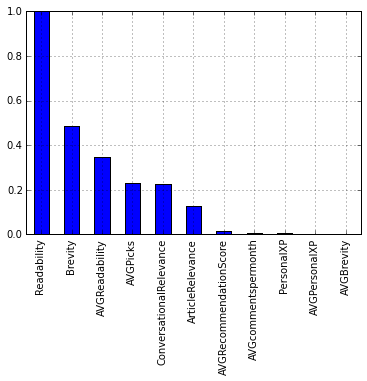

In [48]:
clf.coef_
nor_weights = clf.coef_[0] ** 2
nor_weights /= nor_weights.max()

feature_weights = {}

for label in feature_label:
    feature_weights[label] = {}


for i in range(len(feature_label)):
    feature_weights[feature_label[i]]['NorSVM'] = nor_weights[i]
    feature_weights[feature_label[i]]['SVM'] = clf.coef_[0][i]
    
    
df = pd.DataFrame.from_dict(feature_weights, orient='index')
df = df.sort('NorSVM', ascending=0)
plt.figure()
df['NorSVM'].plot(kind='bar')
# hist = Bar(df, title="Feature weights by SVM", notebook=True)
# hist.show()

### Univariate feature selection wifh F-test



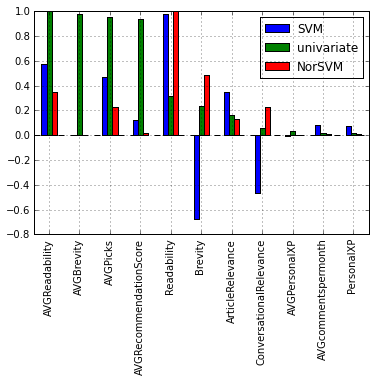

In [49]:
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(X,y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

for i in range(len(feature_label)):
    feature_weights[feature_label[i]]['univariate'] = scores[i]
    
df = pd.DataFrame.from_dict(feature_weights, orient='index')

df = df.sort('univariate', ascending=0)
df.plot(kind='bar')

# plt.figure()
# df.plot(kind='bar')




### Linear regression

In [50]:
regr = linear_model.LogisticRegression(class_weight='auto')


In [51]:
scores = cross_validation.cross_val_score(regr, X, y, cv=5, scoring='f1')

scores

print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


F1: 0.21 (+/- 0.13)


In [52]:
regr.fit(X, y)
regr.coef_

array([[ 0.45075975,  0.12231041, -0.09126729,  0.11543248,  0.41872662,
         0.75564982,  0.18290419, -0.71069814, -0.6142691 ,  0.06420101,
         1.08082725]])

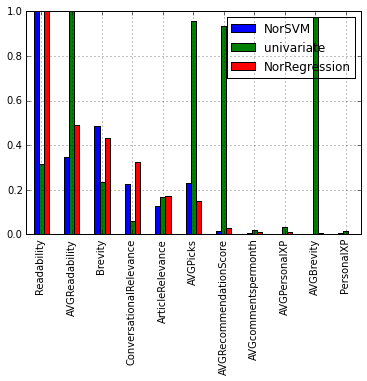

In [53]:
nor_weights = regr.coef_[0] ** 2
nor_weights /= nor_weights.max()



for i in range(len(feature_label)):
    feature_weights[feature_label[i]]['NorRegression'] = nor_weights[i]
    feature_weights[feature_label[i]]['regression'] = regr.coef_[0][i]
    

    
df = pd.DataFrame.from_dict(feature_weights, orient='index')

df = df.sort('NorRegression', ascending=0)

df[:3]
plt.figure()
df[['NorSVM','univariate','NorRegression']].plot(kind='bar')
# hist = Bar(df, title="Univariate Score", notebook=True)
# hist.show()

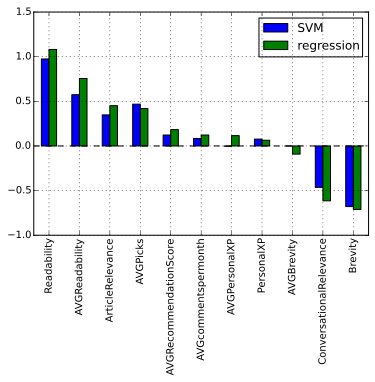

In [54]:
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

# %matplotlib [gui]
df = df.sort('regression', ascending=0)

df[:3]
plt.figure()
df[['SVM','regression']].plot(kind='bar')

In [55]:
coef = regr.coef_[0]

normal_coef = (coef / coef.max())*100

normal_coef

for i in range(len(feature_label)):
    print feature_label[i] + ': ' +  str(normal_coef[i]) +',' 

ArticleRelevance: 41.7050691338,
AVGcommentspermonth: 11.3163696168,
AVGBrevity: -8.44420731416,
AVGPersonalXP: 10.6800123967,
AVGPicks: 38.7413080958,
AVGReadability: 69.9140232479,
AVGRecommendationScore: 16.9226104916,
Brevity: -65.7550166251,
ConversationalRelevance: -56.8332353888,
PersonalXP: 5.93998767753,
Readability: 100.0,


    Let's visualize the performance of classifier.

In [56]:
clf_decision = clf.decision_function(X)

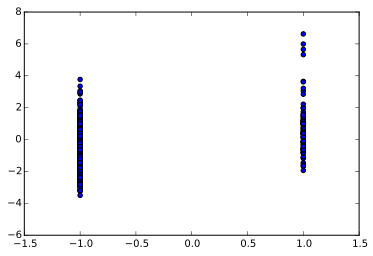

In [57]:
plt.scatter(y,clf_decision)

In [58]:
# desision_df = pd.DataFrame({'Label':y, 'Decision':clf_decision})
# desision_df[:3]

for i in clf_decision:
    clf_decision[i]
clf_decision[1]

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
pos = [1,2,4,5,7,8]
data = [np.random.normal(size=100) for i in pos]

In [ ]:
plt.violinplot(data,pos)